   # Open Source Data about Open Source Software
   
   
Description: Current notebook uses anonymized <a href ="https://archive.org/details/stackexchange"> dump </a> of user-contributed content on the opensource.stackexchange network. It is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. The data dump includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included available <a href="https://ia800107.us.archive.org/27/items/stackexchange/readme.txt">readme.txt</a>.
    For the purposes of current research, only post.xml and tags.xml files were read, parsed, transformed and analyzed.
   
   RQs:
   - What are the most popular tags in <a href = "https://opensource.stackexchange.com/"> opensource stackexchange</a>?
   - What is the interest in tag/ topic ?
   - What are cumulative views of tag in posts?
   - What is the number of posts with specific tag by year? 

In [1]:
# Importing the libraries
import pandas as pd
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
#visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

## Tags
 Steps:
  `read -> parse -> clean -> preprocess -> transform ->visualize`

In [2]:
#reading tags and posts data separately
#posts data had "hugeXML" limitation
tags = pd.read_xml("Tags.xml")

In [3]:
#tags overview
tags.head()

,Id,TagName,Count,ExcerptPostId,WikiPostId
0,2,api,461,59.0,58.0
1,4,government,198,160.0,159.0
2,5,energy,54,5098.0,5097.0
3,13,medical,320,5197.0,5196.0
4,15,city,94,216.0,215.0


In [4]:
#checking the number of unique tags
tags['TagName']=tags['TagName'].apply(lambda x: x.lower().strip())
#number of unique tags
tags['TagName'].nunique()

299

In [5]:
#most popular tag
tags[tags['Count']==tags['Count'].max()]

,Id,TagName,Count,ExcerptPostId,WikiPostId
62,157,data-request,3017,630.0,629.0


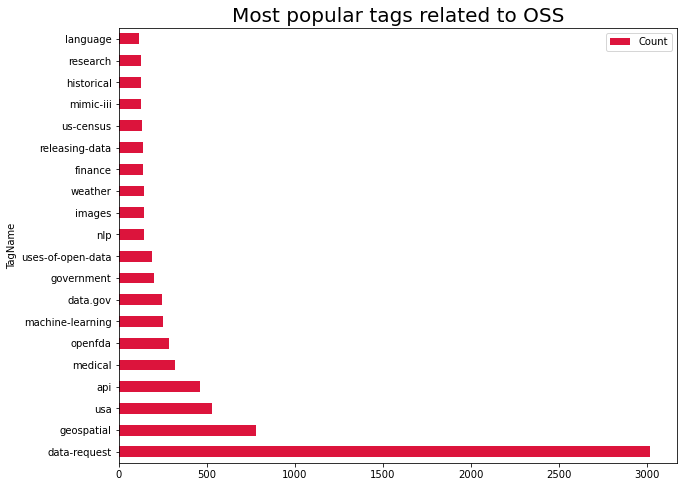

In [6]:
#slicing for visualization
reducedTags=tags.sort_values("Count", ascending=False)[['Count','TagName']].head(20)
#Visualizing the most popular tags related to OSS
reducedTags.plot.barh(x='TagName', y='Count', rot=0, color="crimson", figsize=(10,8))
plt.title("Most popular tags related to OSS",fontdict={"size":20})
plt.show()

# Posts
 Steps:
 1. read the data
 2. understand useful information
 3. parse
 4. clean
 5. transform
 6. visualize

In [7]:
#reading and parsing posts information
tree = ET.parse('Posts.xml')
root = tree.getroot()

In [8]:
# Having an overview of the xml data for further retrieval
for child in root:
    print(child.tag, child.attrib)

row {'Id': '1', 'PostTypeId': '1', 'AcceptedAnswerId': '2', 'CreationDate': '2013-05-08T18:59:12.333', 'Score': '33', 'ViewCount': '3335', 'Body': "<p>Specifically I'm looking for:</p>\n\n<ul>\n<li>Agency canonical names</li>\n<li>Agency abbreviature/acronym</li>\n<li>Hierarchy of agencies e.g. Census Bureau is\npart of Department of Commerce</li>\n<li>Agency logos</li>\n<li>Website/social media accounts</li>\n<li>HQ Address/contact info</li>\n</ul>\n", 'OwnerUserId': '7', 'LastEditorUserId': '70', 'LastEditDate': '2015-03-26T20:36:33.233', 'LastActivityDate': '2017-04-07T19:57:29.857', 'Title': 'Is there a list of all US Government agencies and sub agencies and is it available via API?', 'Tags': '<data-request><usa><government><api>', 'AnswerCount': '12', 'CommentCount': '4', 'FavoriteCount': '11', 'ContentLicense': 'CC BY-SA 3.0'}
row {'Id': '2', 'PostTypeId': '2', 'ParentId': '1', 'CreationDate': '2013-05-08T19:14:48.833', 'Score': '19', 'Body': '<p>Check out:</p>\n\n<ul>\n<li>An of

limit_output extension: Maximum message size of 10000 exceeded with 1377843 characters

In [9]:
#Making a dataframe
dfcols = ['Id','Title', 'Body','Tags', 'ViewCount', 'ActivityDate']
post = pd.DataFrame(columns=dfcols)

for i in tree.iter(tag='row'):
    post = post.append(
        pd.Series([i.get('Id'),i.get('Title'), i.get('Body'), i.get('Tags'), i.get('ViewCount'), i.get('LastActivityDate')], index=dfcols),
        ignore_index=True)

In [10]:
#Posts data overview
post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13264 entries, 0 to 13263
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            13264 non-null  object
 1   Title         5852 non-null   object
 2   Body          13264 non-null  object
 3   Tags          5852 non-null   object
 4   ViewCount     5852 non-null   object
 5   ActivityDate  13264 non-null  object
dtypes: object(6)
memory usage: 621.9+ KB


In [11]:
post.head()

,Id,Title,Body,Tags,ViewCount,ActivityDate
0,1,Is there a list of all US Government agencies ...,<p>Specifically I'm looking for:</p>\n\n<ul>\n...,<data-request><usa><government><api>,3335,2017-04-07T19:57:29.857
1,2,None,<p>Check out:</p>\n\n<ul>\n<li>An official sou...,None,None,2013-05-09T19:55:52.903
2,3,Is there a list of all municipal government fo...,<p>I've found a list of government forms at th...,<usa><government>,108,2013-05-09T20:43:53.963
3,4,None,<p>I'm not sure about an API but here is a lis...,None,None,2013-05-08T19:15:36.803
4,5,None,"<p>It's hard to know if this is canonical, and...",None,None,2013-05-08T19:17:03.953


### Several preprocessing steps
    - dropping posts with no tags
    - removing tag symbols from tags and making them list
    - ensuring there are no repeated tags
    - converting string of date to datetime format

In [12]:
#droping posts with no tags
posts=post.dropna(subset=['Tags']).reset_index(drop=True)
#changing the type of ViewCount
posts['ViewCount']=posts['ViewCount'].apply(lambda x: int(x))
#cleaning tags
posts['Tags']=posts['Tags'].apply(lambda x : x.replace("<","").split(">")[:-1])
#deduplicating tags
posts['Tags']=posts['Tags'].apply(lambda x: list(set(x)))
#converting date
posts['ActivityDate']=pd.to_datetime(posts['ActivityDate'], format='%Y-%m-%d').dt.date.apply(pd.Timestamp)
print(f"New dataframe consists of {posts.shape[0]} entries, {round((posts.shape[0]-post.shape[0])/post.shape[0]*100,2)}%.")

New dataframe consists of 5852 entries, -55.88%.


In [13]:
posts.head()

,Id,Title,Body,Tags,ViewCount,ActivityDate
0,1,Is there a list of all US Government agencies ...,<p>Specifically I'm looking for:</p>\n\n<ul>\n...,"[usa, api, government, data-request]",3335,2017-04-07
1,3,Is there a list of all municipal government fo...,<p>I've found a list of government forms at th...,"[government, usa]",108,2013-05-09
2,6,Is there a list of all utilities that offer th...,<p>I see the Green Button data standard on gre...,"[energy, usa]",698,2015-09-08
3,7,U.S. City and County Web Data (API),<p>Are there any websites that have basic City...,"[data-request, county, api, city, usa]",10735,2016-05-12
4,9,Does any City have POIA (Public Online Informa...,"<p>A few years ago, <a href=""http://sunlightfo...","[sunlight-foundation, city, legal, usa]",126,2015-03-13


In [14]:
#Separating each element of a list
posts.explode("Tags").groupby("Tags").sum()

,ViewCount
Tags,
5-star-scheme,1503
academia,1013
accelerometer,2563
address,24694
aerial-photography,3461
...,...
wikivoyage,3517
wiktionary,1913
wordnet,332


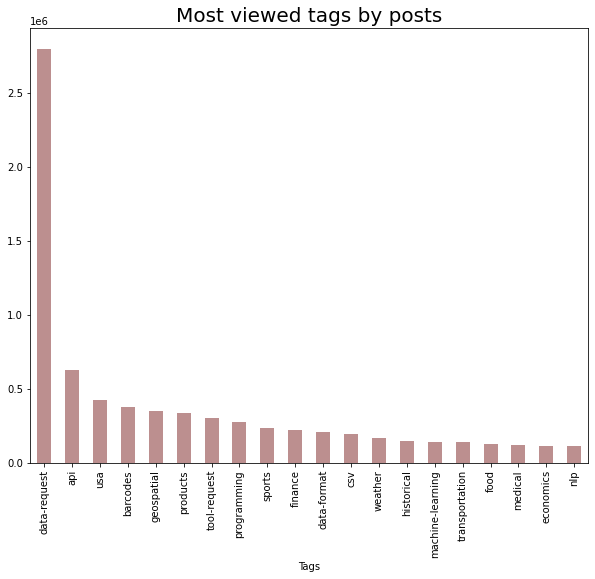

In [15]:
#Visualizing the most widespread tags
reducedPosts=posts.explode("Tags").groupby("Tags").sum()['ViewCount'].sort_values(ascending=False).head(20)
reducedPosts.plot.bar(x='TagName', y='Count', rot=90, color="rosybrown", figsize=(10,8))
plt.title("Most viewed tags by posts",fontdict={"size":20})
#plt.axis([None, None, 100000, 2800000])
plt.show()

### Visualizing timeline of tags 

In [16]:
#transforming data
tgTime=posts[['Tags','ActivityDate']].explode("Tags").sort_values(['Tags',"ActivityDate"]).reset_index(drop=True)
tgTime['Year']=tgTime['ActivityDate'].dt.year
tagsTimeline=tgTime.groupby(['Tags','Year']).count().unstack().fillna(0)
to_use=tagsTimeline.ActivityDate.unstack().reset_index().sort_values(["Tags","Year"]).rename(columns={0:"tagCount"})

In [17]:
tagsTimeline.ActivityDate.tail(20)

Year,2013,2014,2015,2016,2017,2018,2019,2020,2021
Tags,,,,,,,,,
un,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0
unstructured-data,1.0,1.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0
us-census,0.0,0.0,29.0,30.0,21.0,12.0,14.0,15.0,12.0
usa,32.0,18.0,113.0,73.0,80.0,65.0,43.0,52.0,56.0
usaidopen,0.0,0.0,6.0,6.0,4.0,2.0,1.0,1.0,6.0
uses-of-open-data,0.0,2.0,23.0,40.0,26.0,19.0,22.0,28.0,29.0
usgs,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,3.0
video,0.0,0.0,0.0,0.0,0.0,5.0,4.0,3.0,3.0
visualization,0.0,0.0,4.0,1.0,1.0,0.0,0.0,4.0,1.0


In [18]:
def tagByYear(tagName):
    '''Function visualizing user-inputted tag count by years
        Args:
        Input: tagName, str, name of the tag
        Output: seaborn lineplot with given tagName    
    '''
    lnplt=sns.lineplot(data=to_use[to_use['Tags']==tagName], x='Year', 
                       y='tagCount', color='darkgreen')
    lnplt.set_title(f"Number of posts with {tagName} tag by years", fontsize=(16), color="forestgreen")
    axes = lnplt.axes
    axes.set_ylim(0,)
    rcParams['figure.figsize'] = 7,6
    
    return plt.show()

### Number of posts with specific tag by year

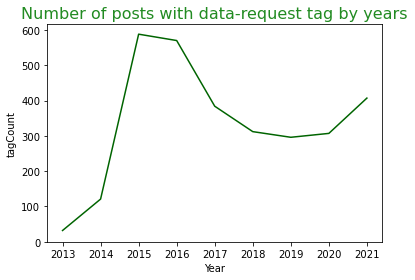

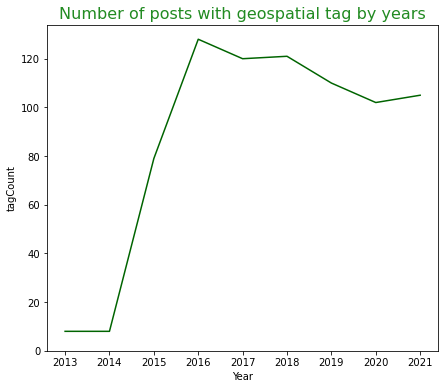

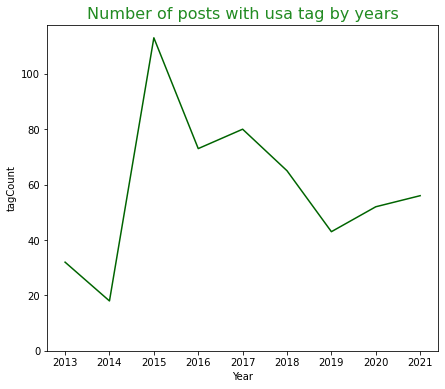

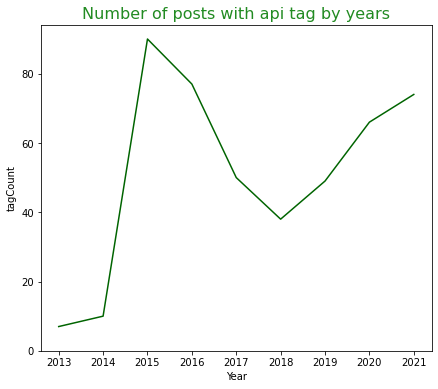

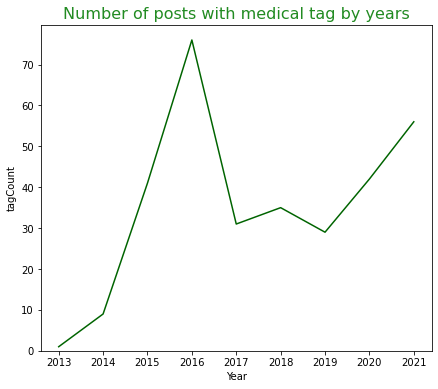

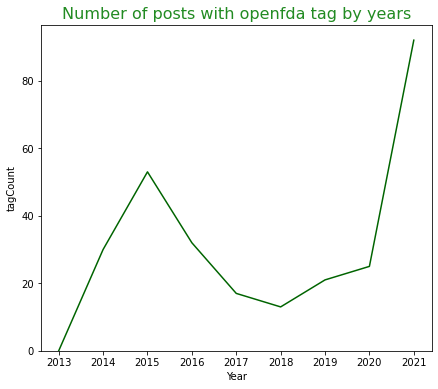

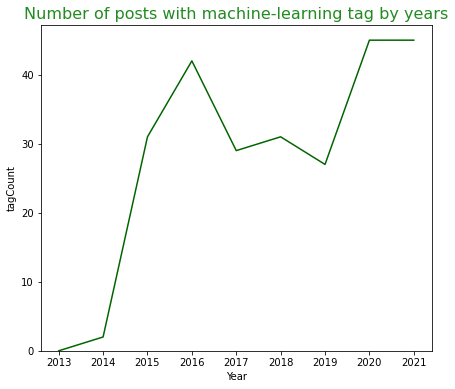

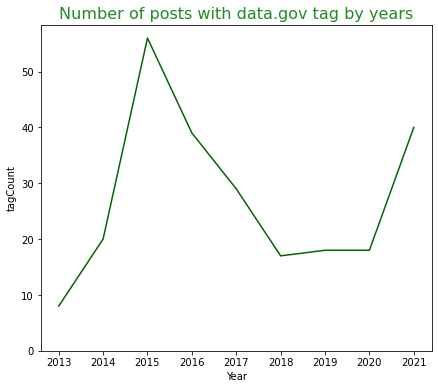

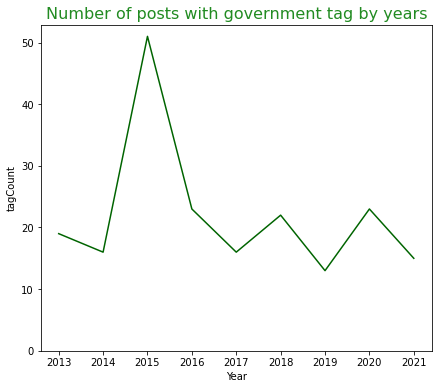

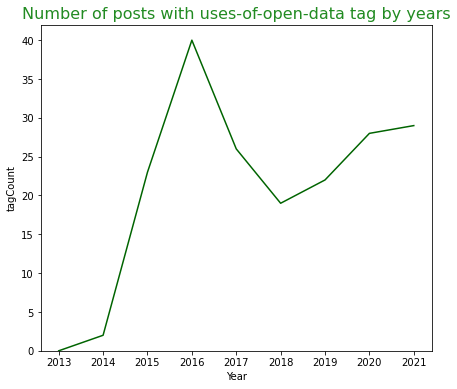

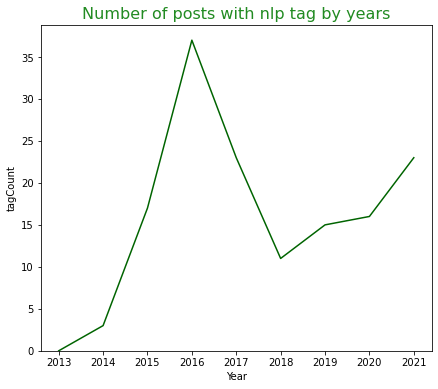

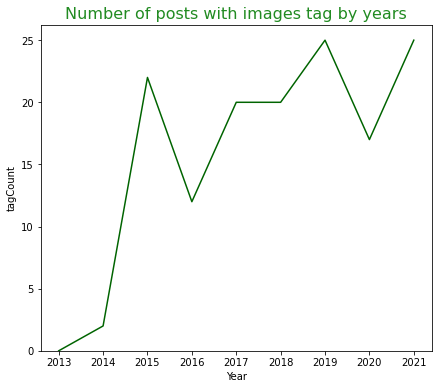

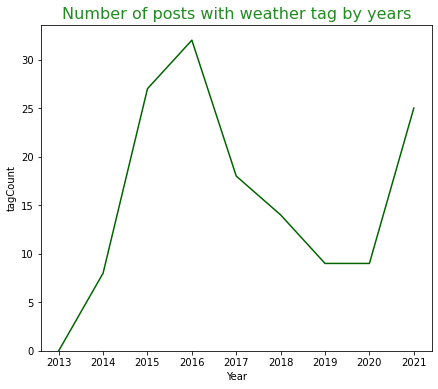

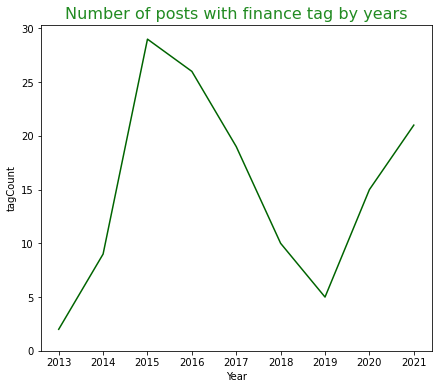

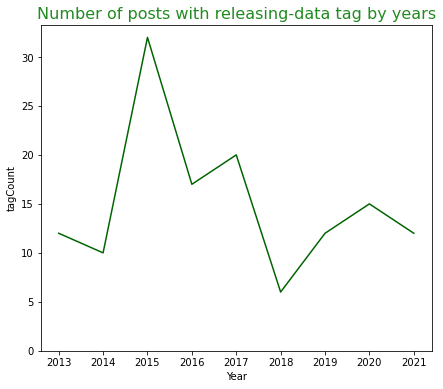

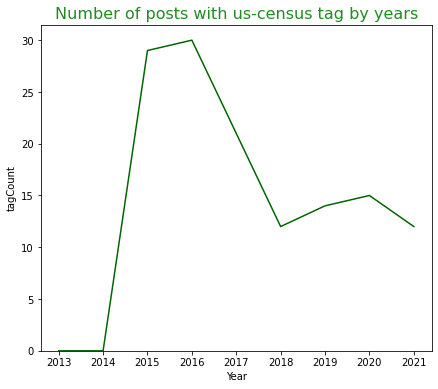

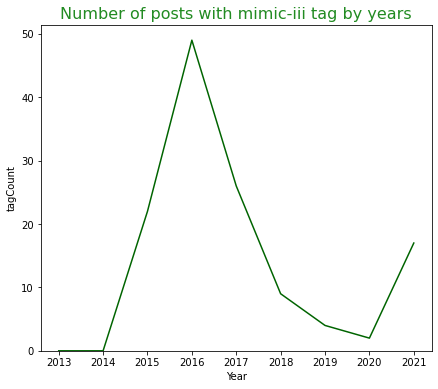

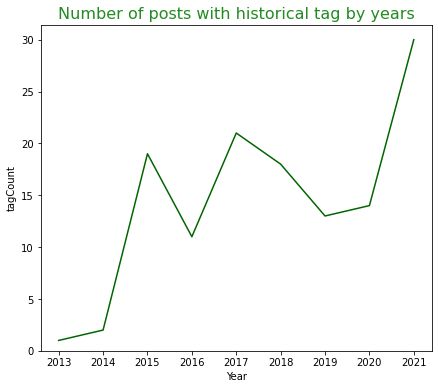

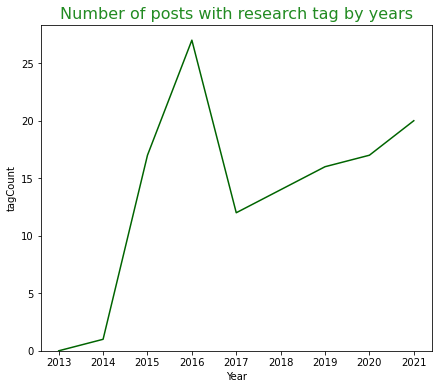

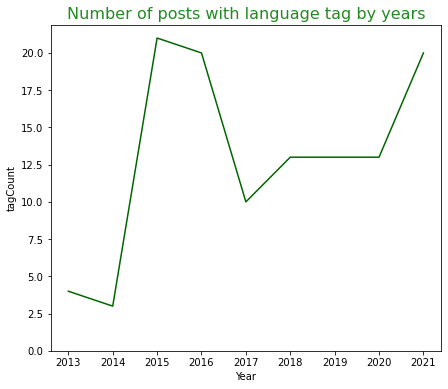

In [19]:
for popularTag in reducedTags['TagName'].tolist():
    tagByYear(popularTag)